#FlowGrad: Controlling the Output of Generative ODEs with Gradients#

## Step 1:
Generate two distributions $\pi_0$ and $\pi_1$ and train a [Rectified Flow](https://github.com/gnobitab/RectifiedFlow) .


Shape of the samples from the target distribution: torch.Size([10000, 2])


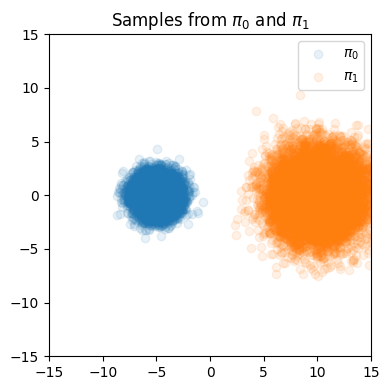

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F

D = 10.
M = D+5
VAR = 5.0
DOT_SIZE = 4

initial_mix = Categorical(torch.tensor([1 for i in range(1)]))
initial_comp = MultivariateNormal(torch.tensor([[-5.0, 0.0]]).float(), torch.stack([torch.eye(2) for i in range(1)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
initial_samples = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1 for i in range(1)]))
target_comp = MultivariateNormal(torch.tensor([[10.0, 0.0]]).float(), VAR*torch.stack([torch.eye(2) for i in range(1)]))
target_model = MixtureSameFamily(target_mix, target_comp)
target_samples = target_model.sample([10000])
print('Shape of the samples from the target distribution:', target_samples.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(initial_samples[:, 0].cpu().numpy(), initial_samples[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(target_samples[:, 0].cpu().numpy(), target_samples[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

In [ ]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

In [ ]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


In [ ]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(100):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [ ]:
x0 = initial_model.sample([50000])
x1 = target_samples.repeat(5, 1)
x_pairs = torch.stack([x0, x1], dim=1)
print(x_pairs.shape)

torch.Size([50000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

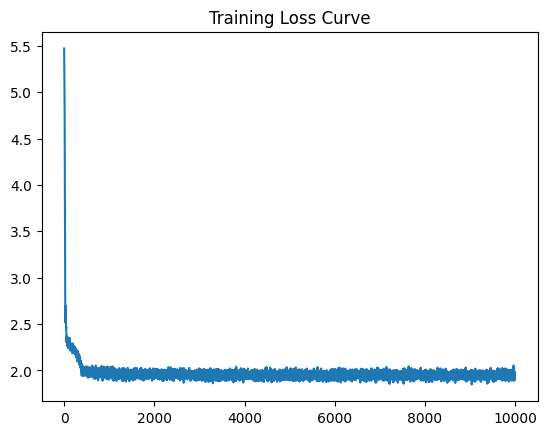

In [ ]:
iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=1000)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

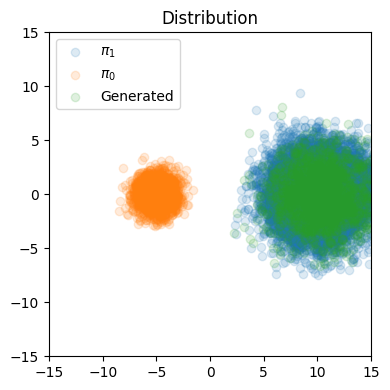

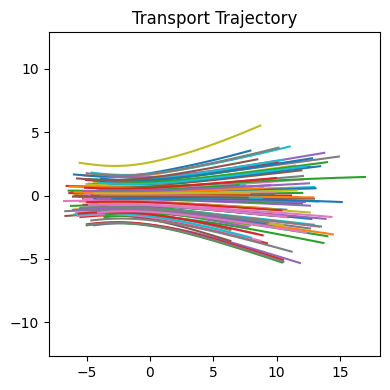

In [ ]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=target_samples.detach().clone())

## Step 2: control the output with FlowGrad

Now we have the PF ODE model and we can control it with FlowGrad.
We use a very simple loss.
Denote the end point of the PF ODE as $z_1 = (x,y)$, we define the loss function as $L(z_1) = (x-10)^2 + (y-5)^2$.
We want to optimize the trajectory to minimize $L(z_1)$, where $p$ is the end point of the trajectory.

In [ ]:
def flowgrad_optimization(z0, u_ind, dynamic, generate_traj, N=100, L_N=None, u_init=None,  number_of_iterations=10, penalty_coeff=0.0,
                                  straightness_threshold=5e-3, lr=1.0):
    device = z0.device
    shape = z0.shape
    u = {}
    if u_init is None:
        for ind in u_ind:
            u[ind] = torch.zeros_like(z0).to(z0.device)
            u[ind].requires_grad = True
            u[ind].grad = torch.zeros_like(u[ind], device=u[ind].device)
    else:
        for ind in u_init.keys():
            u[ind] = u_init[ind].detach().clone().to(z0.device)

        for ind in u_ind:
            try:
                u[ind].requires_grad = True
            except:
                u[ind] = torch.zeros_like(z0).to(z0.device)
                u[ind].requires_grad = True
            u[ind].grad = torch.zeros_like(u[ind], device=u[ind].device)

    u_optimizer = torch.optim.SGD([u[key] for key in u_ind], lr=lr) ### white black 5e-3

    ### L is supposed to be a function (ideally, a lambda expression). The output of L should a scalar.
    for i in range(number_of_iterations):
        u_optimizer.zero_grad()

        ### get the forward simulation result and the non-uniform discretization trajectory
        ### non_uniform_set: indices and interval length (t_{j+1} - t_j)
        z_traj, non_uniform_set = generate_traj(dynamic, z0, u=u, N=N, straightness_threshold=straightness_threshold)

        ### use lambda to store \nabla L
        inputs = torch.zeros(z_traj[-1].shape, device=device)
        inputs.data = z_traj[-1].to(device).detach().clone()
        inputs.requires_grad = True
        loss = L_N(inputs)
        lam = torch.autograd.grad(loss, inputs)[0]
        lam = lam.detach().clone()

        print('Iteration:', i)
        print('   End point :', inputs.view(-1).detach().cpu().numpy())
        print('   L:%.6f'%loss.detach().cpu().numpy())
        print('   Nabla L:', lam.reshape(-1).detach().cpu().numpy())

        eps = 1e-3 # default: 1e-3
        g_old = None
        d = []
        for j in range(N-1, -1, -1):
            if j in non_uniform_set['indices']:
              assert j in u_ind
            else:
              continue

            ### compute lambda with vjp
            inputs = torch.zeros(lam.shape, device=device)
            inputs.data = z_traj[j].to(device).detach().clone()
            inputs.requires_grad = True
            t = torch.ones((1, 1)) * j / N
            func = lambda x: (x.contiguous().reshape(shape) + u[j].detach().clone() + \
                                  dynamic(x.contiguous().reshape(shape) + u[j].detach().clone(), t.detach().clone()) * non_uniform_set['length'][j]/N).view(-1)
            output, vjp = torch.autograd.functional.vjp(func, inputs=inputs.view(-1), v=lam.detach().clone().reshape(-1))
            lam = vjp.detach().clone().contiguous().reshape(shape)

            u[j].grad = lam.detach().clone()
            del inputs
            if j == 0: break

        ### Re-assignment
        for j in range(len(non_uniform_set['indices'])):
            start = non_uniform_set['indices'][j]
            try:
              end = non_uniform_set['indices'][j+1]
            except:
              end = N

            for k in range(start, end):
              if k in u_ind:
                u[k].grad = u[start].grad.detach().clone()

        u_optimizer.step()

    opt_u = {}
    for ind in u.keys():
        opt_u[ind] = u[ind].detach().clone()

    return opt_u

@torch.no_grad()
def generate_traj(dynamic, z0, u=None, N=100, straightness_threshold=None):
  traj = []
  # Initial sample
  z = z0.detach().clone()
  traj.append(z.detach().clone().cpu())
  batchsize = z0.shape[0]

  dt = 1./N
  pred_list = []
  for i in range(N):
    if (u is not None):
        try:
            z = z + u[i]
        except:
            pass

    t = torch.ones((batchsize,1)) * i / N
    pred = dynamic(z, t)
    z = z.detach().clone() + pred * dt

    traj.append(z.detach().clone())

    pred_list.append(pred.detach().clone().cpu())

  if straightness_threshold is not None:
      ### compute straightness and construct G
      non_uniform_set = {}
      non_uniform_set['indices'] = []
      non_uniform_set['length'] = {}
      accumulate_length = 0
      accumulate_straightness = 0
      cur_index = 0
      for i in range(N):
          try:
            d1 = (pred_list[i-1] - pred_list[i]).pow(2).sum() / pred_list[i].pow(2).sum()
          except:
            d1 = 0

          try:
            d2 = (pred_list[i+1] - pred_list[i]).pow(2).sum() / pred_list[i].pow(2).sum()
          except:
            d2 = 0

          d = max(d1, d2)
          accumulate_straightness += d
          accumulate_length += 1
          if (accumulate_straightness > straightness_threshold) or (i==(N-1)):
            non_uniform_set['length'][cur_index] = accumulate_length
            non_uniform_set['indices'].append(cur_index)

            accumulate_straightness = 0
            accumulate_length = 0
            cur_index = i+1

      return traj, non_uniform_set
  else:
      return traj

We randomly initilize a $z0$, and optimize the end point $z_1$ with FlowGrad; The loss gradually decreases

(If the end point is not optimized to (10,5), try optimize it for longer time or change intial z0).

In [ ]:
z0 = initial_model.sample([1])
print('z0 at initialization:', z0)
L = lambda x: (x[:, 0] - 10.).pow(2).sum() + (x[:, 1] - 5.).pow(2).sum()
model_fn = rectified_flow_1.model

traj = generate_traj(model_fn, z0=initial_model.sample([2000]), N=100)
traj_org = generate_traj(model_fn, z0=z0, N=100)

opt_u = flowgrad_optimization(z0.detach().clone(), u_ind=[i for i in range(100)], \
                                      dynamic=model_fn, generate_traj=generate_traj, N=100, L_N=L, number_of_iterations=30, penalty_coeff=1e-3, straightness_threshold=1e-3, lr=0.0005)

traj_opt = generate_traj(model_fn, z0=z0, u=opt_u, N=100)
print('z0 after FlowGrad optimization:', traj_opt[-1])

z_traj_cllt = []
z_traj_cllt.append(traj_org)
z_traj_cllt.append(traj_opt)

z0 at initialization: tensor([[-6.4145e+00,  4.3178e-03]])
Iteration: 0
   End point : [ 7.0263166  -0.01519916]
   L:33.995018
   Nabla L: [ -5.9473667 -10.030398 ]
Iteration: 1
   End point : [7.735842  1.2507033]
   L:19.183636
   Nabla L: [-4.5283155 -7.4985933]
Iteration: 2
   End point : [8.329203  2.1407316]
   L:10.966980
   Nabla L: [-3.3415947 -5.718537 ]
Iteration: 3
   End point : [8.789061  2.8369029]
   L:6.145364
   Nabla L: [-2.4218788 -4.3261943]
Iteration: 4
   End point : [9.107976 3.369046]
   L:3.455718
   Nabla L: [-1.7840481 -3.261908 ]
Iteration: 5
   End point : [9.343732 3.816004]
   L:1.832534
   Nabla L: [-1.3125362 -2.367992 ]
Iteration: 6
   End point : [9.52187   4.1656933]
   L:0.924676
   Nabla L: [-0.9562607 -1.6686134]
Iteration: 7
   End point : [9.655002  4.4228053]
   L:0.452178
   Nabla L: [-0.6899967 -1.1543894]
Iteration: 8
   End point : [9.753595  4.6069636]
   L:0.215193
   Nabla L: [-0.4928093  -0.78607273]
Iteration: 9
   End point : [9.824

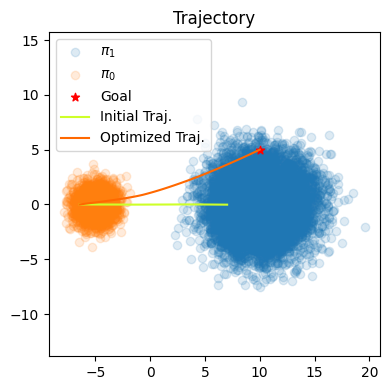

In [ ]:
plt.figure(figsize=(4, 4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.axis('equal')

plt.scatter(target_samples[:, 0].cpu().numpy(), target_samples[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
plt.scatter([10.], [5.], label='Goal', alpha=1.0, marker='*', c='r')

from matplotlib import cm
number_of_lines= len(z_traj_cllt)
cm_subsection = np.linspace(0.6, 0.8, number_of_lines)
colors = [ cm.jet(x) for x in cm_subsection ]
traj_particles = torch.stack(z_traj_cllt[0])
plt.plot(traj_particles[:, 0, 0], traj_particles[:, 0, 1], color=colors[0], label='Initial Traj.')
traj_particles = torch.stack(z_traj_cllt[1])
plt.plot(traj_particles[:, 0, 0], traj_particles[:, 0, 1], color=colors[1], label='Optimized Traj.')

plt.legend()
plt.title('Trajectory')
plt.tight_layout()